In [74]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm

In [75]:
# Importing dataset
columns = ['lenght_of_stay', 'age', 'infection_risk', 'routine_culturing_ratio', 'routine_xray_ratio', 'num_beds', 'med_school_affil', 'region', 'avg_census', 'num_nurses', 'avelbl_services']
df = pd.read_csv("data/dataset.txt", sep=" ", header=None, names=columns)
df.head()

,lenght_of_stay,age,infection_risk,routine_culturing_ratio,routine_xray_ratio,num_beds,med_school_affil,region,avg_census,num_nurses,avelbl_services
1,7.13,55.7,4.1,9.0,39.6,279,2,4,207,241,60.0
2,8.82,58.2,1.6,3.8,51.7,80,2,2,51,52,40.0
3,8.34,56.9,2.7,8.1,74.0,107,2,3,82,54,20.0
4,8.95,53.7,5.6,18.9,122.8,147,2,4,53,148,40.0
5,11.20,56.5,5.7,34.5,88.9,180,2,1,134,151,40.0


In [76]:
# One-hot encoding categorical variables
df = pd.get_dummies(df, columns=['med_school_affil', 'region'])
df.head()

,lenght_of_stay,age,infection_risk,routine_culturing_ratio,routine_xray_ratio,num_beds,avg_census,num_nurses,avelbl_services,med_school_affil_1,med_school_affil_2,region_1,region_2,region_3,region_4
1,7.13,55.7,4.1,9.0,39.6,279,207,241,60.0,False,True,False,False,False,True
2,8.82,58.2,1.6,3.8,51.7,80,51,52,40.0,False,True,False,True,False,False
3,8.34,56.9,2.7,8.1,74.0,107,82,54,20.0,False,True,False,False,True,False
4,8.95,53.7,5.6,18.9,122.8,147,53,148,40.0,False,True,False,False,False,True
5,11.20,56.5,5.7,34.5,88.9,180,134,151,40.0,False,True,True,False,False,False


In [77]:
# Doing a ln transformation on the variables that we noticed 
# a logarithmic relationship with infection_risk in our data profile

df['ln_num_nurses'] = np.log(df['num_nurses'])
df['ln_num_beds'] = np.log(df['num_beds'])
df['ln_avg_census'] = np.log(df['avg_census'])

# Dropping original columns
df.drop(columns=['num_nurses', 'num_beds', 'avg_census'], inplace=True)

In [78]:
# Viewing highest correlations with infection risk

corr_matrix = df.corr()
corr_matrix['infection_risk'].sort_values(ascending=False)

infection_risk             1.000000
routine_culturing_ratio    0.559159
ln_num_nurses              0.545871
lenght_of_stay             0.533444
ln_avg_census              0.461560
routine_xray_ratio         0.453392
ln_num_beds                0.448110
avelbl_services            0.412601
med_school_affil_1         0.233030
region_1                   0.217480
region_2                   0.018307
region_4                   0.008026
age                        0.001093
region_3                  -0.223618
med_school_affil_2        -0.233030
Name: infection_risk, dtype: float64

In [79]:
# Separating covariates and target
if 'infection_risk' in df.columns:
    Y = df.pop("infection_risk").astype(float)

In [80]:
# Normalizing dataset (each column is normalized separately)
df -= df.mean() 
df /= df.std()

In [81]:
# Creating datasets with lower number of variables, to test different models
# topX means: df with the X variables that had the highest correlation
df_complete = df.astype(float)
df_top8 = df.drop(columns=['age', 'region_1', 'region_2', 'region_3', 'region_4',]).astype(float)
df_top5 = df_top8.drop(columns=['med_school_affil_1', 'med_school_affil_2', 'avelbl_services', 'ln_num_beds']).astype(float)
df_top4 = df_top5.drop(columns='routine_xray_ratio').astype(float)
df_top3 = df_top4.drop(columns='ln_avg_census').astype(float)
df_top2 = df_top3.drop(columns='lenght_of_stay').astype(float)
dfs = [df_complete, df_top8, df_top5, df_top4, df_top3, df_top2]

In [82]:
# Instantiating one model for each dataset previously prepared
model_complete = pm.Model()
model_top8 = pm.Model()
model_top5 = pm.Model()
model_top4 = pm.Model()
model_top3 = pm.Model()
model_top2 = pm.Model()

models = [model_complete, model_top8, model_top5, model_top4, model_top3, model_top2]

In [83]:
# Defining each model
for df, model in zip(dfs, models): # The order of the dfs and models must be aligned
    with model:
        # Priors for unknown model parameters
        alpha = pm.Normal("alpha", mu=0, sigma=10)
        beta = pm.Normal("beta", mu=0, sigma=10, shape=df.shape[1]) # Number of betas varies with number of covariates in the dataset
        sigma = pm.HalfNormal("sigma", sigma=1)

        # Expected value of outcome
        mu = alpha + pm.math.dot(df, beta)

        # Likelihood (sampling distribution) of observations
        Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [84]:
idata = []

# Sampling each model
for i, model in enumerate(models):
    with model:
        step = pm.Metropolis()
        idata.append(pm.sample(10000, step=step, idata_kwargs = {'log_likelihood': True}))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 35 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 32 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 45 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 45 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 46 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 45 seconds.


In [85]:
model_trace_dict = dict() # {'model_name': idata-of-that-model}

for i, num in enumerate(['df_complete', 'df_top8', 'df_top5', 'df_top4', 'df_top3', 'df_top2']):
    models[i].name = num
    model_trace_dict.update({num: idata[i]})

In [86]:
# Calculates waic measure for each of the models in the dict
dfwaic = az.compare(model_trace_dict, ic='waic')

c:\Users\davig\anaconda3\envs\comp_stats\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\davig\anaconda3\envs\comp_stats\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\davig\anaconda3\envs\comp_stats\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\davig\anaconda3\envs\comp_stats\Lib\site-packages\arviz\stats\stats

In [87]:
dfwaic

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
df_complete,0,-151.453017,13.443697,0.000000,0.560067,7.345575,0.000000,True,log
df_top5,1,-151.883549,6.889572,0.430533,0.207403,7.395347,3.942460,True,log
df_top4,2,-152.989281,6.199772,1.536264,0.048390,7.661187,4.509232,True,log
df_top8,3,-153.188563,9.490570,1.735547,0.000000,7.291216,3.517043,True,log
df_top3,4,-154.177962,5.598993,2.724945,0.184140,7.663544,4.987243,True,log
df_top2,5,-159.958774,4.834709,8.505758,0.000000,7.664788,5.808858,True,log


It seems to me that the performance of the complete data and the top_5 covariates are realy similar (elpd_waic measure), but the top_5 model has half the complexity of the complete model.
This makes me conclude that the best model would be the model_top5 (indice 2)

In [88]:
# Plot summary of parameters
az.summary(idata[2], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,4.35,0.08,4.20,4.52,0.00,0.00,5575.18,6018.31,1.0
beta[0],0.37,0.11,0.15,0.57,0.00,0.00,2271.00,3097.02,1.0
beta[1],0.41,0.10,0.22,0.59,0.00,0.00,3425.35,3811.94,1.0
beta[2],0.20,0.10,0.00,0.39,0.00,0.00,2692.48,4180.28,1.0
beta[3],0.78,0.22,0.37,1.18,0.01,0.01,607.40,1174.39,1.0
beta[4],-0.37,0.23,-0.77,0.06,0.01,0.01,606.60,1216.81,1.0
sigma,0.90,0.06,0.79,1.02,0.00,0.00,4127.09,5386.56,1.0


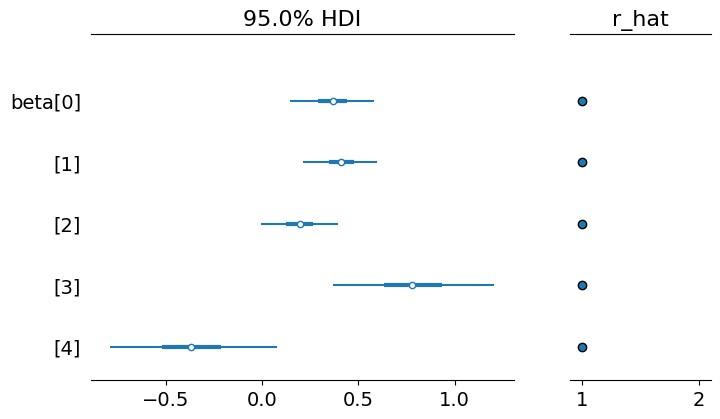

In [89]:
# Plot parameters for covariates
az.plot_forest(idata[2], var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);

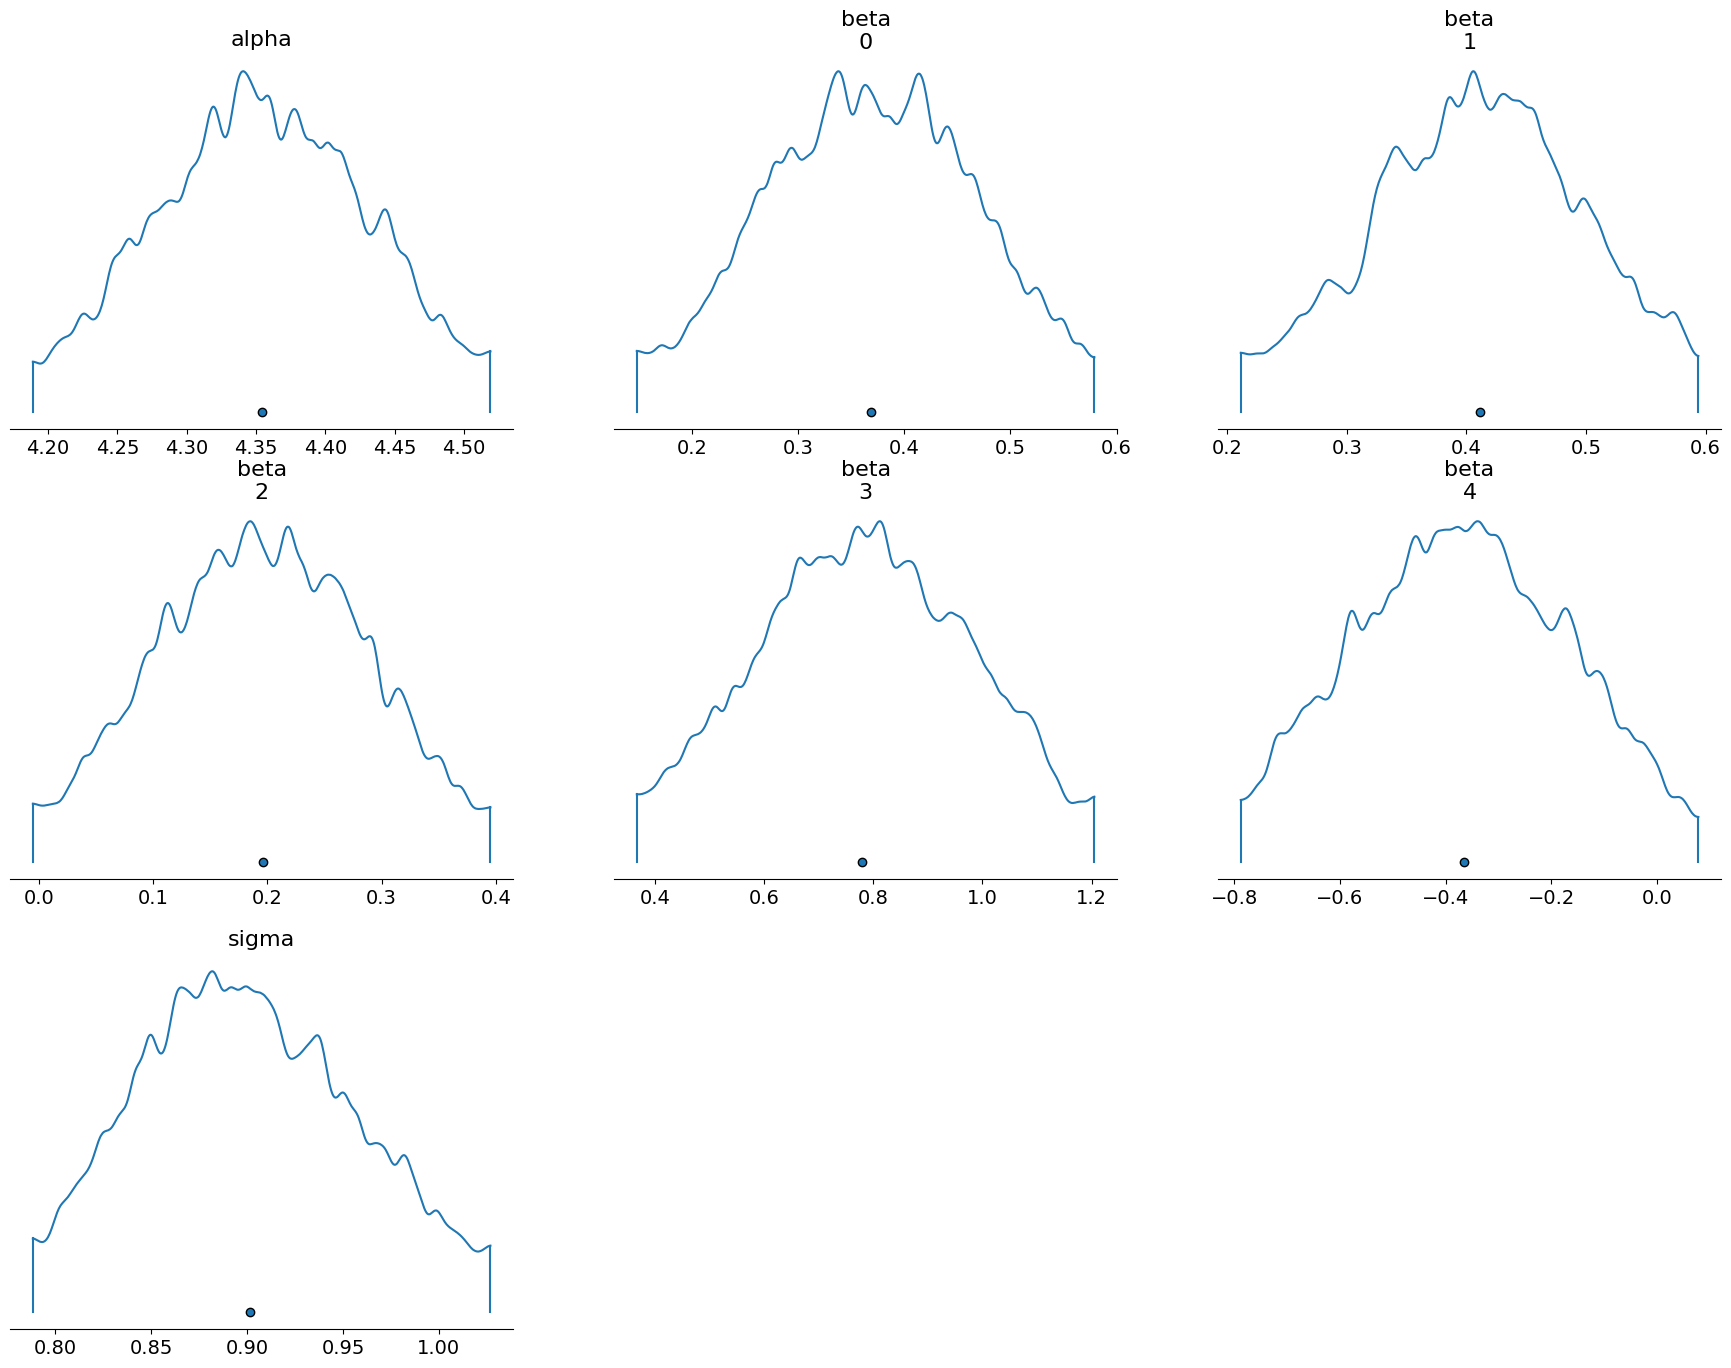

In [92]:
# Plot posterior densities of parameters
az.plot_density(idata[2], group='posterior', hdi_prob=0.95);

In [90]:
Y_pred = pm.sample_posterior_predictive(idata[2], model=models[2]) # for each sample it draws a beta from each found beta distribution -> finds Y_pred for all X

Sampling: [Y_obs]


<Axes: xlabel='Y_obs / Y_obs'>

c:\Users\davig\anaconda3\envs\comp_stats\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\davig\anaconda3\envs\comp_stats\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


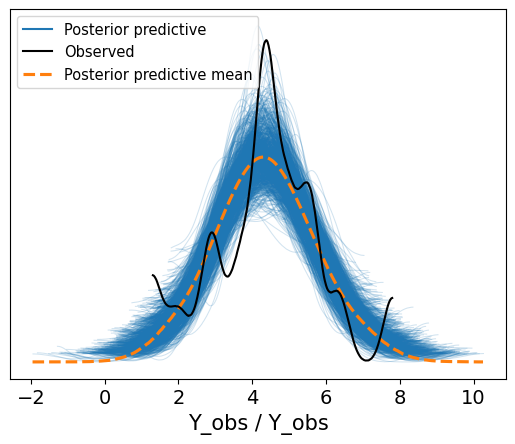

In [91]:
import matplotlib.pyplot as plt
# # fig, ax = plt.subplots()
# # plt.xlim(0,10)
# # az.plot_ppc(Y_pred, num_pp_samples=100, ax=ax)
az.plot_ppc(Y_pred, num_pp_samples=1000)